# Item_based collaborative ranking

<span style="color:pink; font-size:20px ">Implemented by Malihe Ghazalian</span>

In [1]:
#ADD Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from networkx.algorithms import bipartite
import time

## Load dataset

In [2]:
# Read the ratings data from Movielense 100k
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratingData = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_columns)

In [3]:
ratingData.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
num_users = ratingData['user_id'].max()
num_movies = ratingData['movie_id'].max()

In [13]:
print("Number of users: ", num_users, "\n")
print("Number of movies: ", num_movies)

Number of users:  943 

Number of movies:  1682


In [14]:
print(ratingData.shape, "\n")

(100000, 4) 



## Create Pairwise preference dataset
We need to create pairwise preference dataset out of Movielense 100k rating dataset

In [135]:
user_rating = ratingData.groupby('user_id')

In [139]:
train_user_rating = {}
test_user_rating = {}
values = [10, 20, 30, 40]

# Assuming user_rating is a dictionary where keys are user IDs
for uid, urates in user_rating:
    random_value = random.choice(values)
    train_user_rating[uid] = {}
    test_user_rating[uid] = {}
    
    if len(urates) > 10:
        # Sample a random value 
        random_value = min(random_value, len(urates))
        
        train_ratings = urates.sample(n=random_value)
        test_ratings = urates.drop(train_ratings.index)
    
        # Assign ratings to the training set
        for index, row in train_ratings.iterrows():
            train_user_rating[uid][row['movie_id']] = row['rating']
            
        # Assign ratings to the test set
        for index, row in test_ratings.iterrows():
            test_user_rating[uid][row['movie_id']] = row['rating']

In [46]:
# Function to generate pairwise preferences for a user
def generate_pairwise_preferences_for_user(user_id, user_ratings):
    pairwise_preferences = []
    for movie_id1, rating1 in user_ratings.items():
        for movie_id2, rating2 in user_ratings.items():
            if movie_id1 != movie_id2:
                preference = 1 if rating1 > rating2 else None
                if preference:
                    pairwise_preferences.append((user_id, movie_id1, movie_id2))
    return pairwise_preferences

In [ ]:
train_pairwise_preferences = []
test_pairwise_preferences = []
for uid, user_rates in train_user_rating.items():
    pairwise_preferences = generate_pairwise_preferences_for_user(uid, user_rates)
    train_pairwise_preferences.extend(pairwise_preferences)
    
    print("done for user ", uid)

In [50]:
# Convert to DataFrame and save or further process as needed
train_pairwise_df = pd.DataFrame(train_pairwise_preferences, columns=['user_id', 'wining_item', 'losing_item'])
test_pairwise_df = pd.DataFrame(test_pairwise_preferences, columns=['user_id', 'wining_item', 'losing_item'])
train_pairwise_df.to_csv('ml-100k/pairwise_preferences.csv', index=False)
test_pairwise_df.to_csv('ml-100k/pairwise_preferences.csv', index=False)

## Network Construction
<div style="font-size: "> our network contains 2 bipartite network which are LNet, WNet <div>

In [4]:
pairwise_preferences_dataset_names = ['user_id', 'wining_item', 'losing_item']
train_pairwise_data = pd.read_csv('ml-100k/train_pairwise_preferences.csv')
test_pairwise_data = pd.read_csv('ml-100k/test_pairwise_preferences.csv')

In [12]:
train_pairwise_data.head()

,user_id,wining_item,losing_item
0,1,195,118
1,1,195,128
2,1,195,138
3,1,195,254
4,1,195,149


In [11]:
print(train_pairwise_data.shape)

(214180, 3)


In [10]:
print(train_pairwise_data.values)

[[   1  195  118]
 [   1  195  128]
 [   1  195  138]
 ...
 [ 943   27   72]
 [ 943   27  228]
 [ 943   27 1028]]


#### ADD Edges for creating networks

In [5]:
# Network Edges
Ew = []
El = []
users = set()
win_items = set()
lose_items = set()

for item in train_pairwise_data.values:
    user_id = item[0]
    prefered = item[1]
    notPrefered = item[2]

    # Append edge and update sets of users and movies
    Ew.append((str(user_id), prefered, {'label': notPrefered}))
    El.append((str(user_id), notPrefered, {'label': prefered} ))
    
    users.add(str(user_id))
    win_items.add(prefered)
    lose_items.add(notPrefered)

# Create a bipartite graph
WNet = nx.Graph()
LNet = nx.Graph()

# Add nodes to WNet
WNet.add_nodes_from(users, bipartite=0, type='user')  # Users
WNet.add_nodes_from(win_items, bipartite=1, type='item')  # Winning items

# Add nodes to LNet
LNet.add_nodes_from(users, bipartite=0, type='user')  # Users
LNet.add_nodes_from(lose_items, bipartite=1, type='item')  # Losing items

# # Add edges
WNet.add_edges_from(Ew)
LNet.add_edges_from(El)

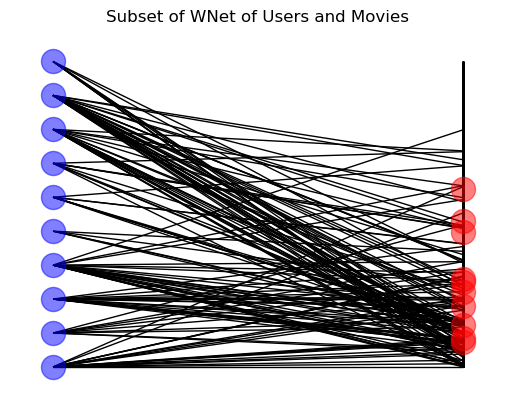

In [16]:
# Randomly select a subset of users and movies for visualization
subset_users = random.sample(list(users), k=10)  
subset_movies = random.sample(list(win_items), k=10)  

# Draw the bipartite graph
pos = nx.bipartite_layout(WNet, subset_users)  

# Draw nodes for the subset
nx.draw_networkx_nodes(WNet, pos, nodelist=subset_users, node_color='b', alpha=0.5)  # Users
nx.draw_networkx_nodes(WNet, pos, nodelist=subset_movies, node_color='r', alpha=0.5)  # Movies

# Draw edges
nx.draw_networkx_edges(WNet, pos)

# Draw labels 
# nx.draw_networkx_labels(WNet, pos)

# Show plot
plt.title("Subset of WNet of Users and Movies")
plt.axis('off') 
plt.show()

#### Create Pu, Wu and Lu
<div style = "font: 20px; color: light-blue"> We need to create a set of pairwise preference for each user and also create a set of winning items and set of lossing items based  on each user.</div>

In [6]:
O = train_pairwise_data.groupby('user_id')

In [7]:
# Create pairwise preferences group by users name it pu
pu = {}
for row in O:
    user_id = row[0]
    if user_id not in pu:
        pu[user_id] = []
    for pair_row in row[1].values:
        pu[user_id].append(pair_row)

In [8]:
print(len(pu))

942


In [9]:
Wu = {}
Lu = {}
for row in O:
    user_id = row[0]
    winning_items = set()
    losing_items = set()
    
    if user_id not in Wu:
        Wu[user_id] = []
        Lu[user_id] = []
    for i in row[1].values:
        _, winning_item, losing_item = i
        winning_items.add(winning_item)
        losing_items.add(losing_item)
        
    Wu[user_id].append(winning_items)
    Lu[user_id].append(losing_items)
    

# Create Algorithms to calculate item ranks

##### PreNIt recomendation 

In [10]:
def calculateWinningFrequency(O, i):
    iter = 0
    for item in O:
        if item[1] == i:
            iter += 1
    return iter

In [11]:
def calculateLosingFrequency(O, i):
    iter = 0
    for item in O:
        if item[2] == i:
            iter += 1
    return iter

In [12]:
def generate_Tu(c, graph, num_users, num_movies):
    user_nodes = {node for node, data in graph.nodes(data=True) if data['bipartite'] == 0}
    Tu = np.zeros((num_users, num_movies))
    label = c
    du = {}
    # Loop over each user node
    for id, user in enumerate(user_nodes):
        user_edge_counts = 0
        neighbors = set()
        # Iterate over neighbors
        for neighbor in graph.neighbors(user):
            # Get the edge label
            edge_label = graph[user][neighbor]['label']
            neighbors.add(neighbor)
            # Check if the edge label matches the specified label
            if edge_label == label:
                user_edge_counts += 1
        
        # Calculate du for the user node
        du[id] = (1/user_edge_counts) if user_edge_counts != 0 else 0
        
        i = int(user) - 1
        for j, neighbor in enumerate(neighbors):
            Tu[i, j-1] = du[id]
            
    return Tu


In [13]:
def generate_Ti(c, graph, num_users, num_movies):
    item_nodes = {node for node, data in graph.nodes(data=True) if data['bipartite'] == 1}
    Ti = np.zeros((num_movies, num_users))
    label = c
    node_degrees = dict(nx.degree(graph))
        # Loop over each user node
    for item in item_nodes:
        di = 1/node_degrees[item] if node_degrees[item] != 0 else 0
            
        # Iterate over neighbors
        for neighbor in graph.neighbors(item):
            # Get the edge label
            edge_label = graph[item][neighbor]['label']
            if edge_label == label:
                i = item - 1
                j = int(neighbor) -1
                Ti[i, j] = di
    return Ti

In [14]:
def init_score_vectors(n, m):
    # Generate random vector for Mi
    Mi = np.random.rand(m, 1)
    Mi /= np.sum(Mi)  # Normalize to ensure sum equals 1

    # Generate random vectors for Mu for each labels
    Mu = {}
    sum_mu_vectors = np.zeros((n, 1))
    for label in range(1, m):
        Mu[label] = np.random.rand(n, 1)
        Mu[label] /= np.sum(Mu[label])  # Normalize to ensure sum equals 1
        sum_mu_vectors = sum_mu_vectors + Mu[label]

    # Sumation of all Mu vectors
    sum_of_values = np.sum(sum_mu_vectors) + np.sum(Mi)

    #Normalize Mu and Mi vectors 
    Mi /= sum_of_values
    for label in Mu:
        Mu[label] /= sum_of_values
        
    return Mi, Mu

In [91]:
def get_graph_labels(graph):
    # Initialize an empty set to store edge labels
    edge_labels = set()

    # Iterate over the edges and collect labels
    for u, v, data in graph.edges(data=True):
        edge_labels.add(data['label'])
        
    return edge_labels

In [94]:
def MemoRank(Tuc, Tic, R_, m, n, graph_labels):
    alpha = 0.85
    # Ensure that R sum up to 1 
    sum_Rw = sum(R_)
    R_ = [element / sum_Rw for element in R_]
    R_ = np.array(R_)
    #initialize Mi and Mu for each label
    Mi, Mu = init_score_vectors(n, m)
    Mu_new = {}
    Mi_new = np.zeros((m, 1))
    converge = False
    convergence_threshold = 1e-6
    t = 0
    # Start time
    start_time = time.time()
    while not converge:
        print("iteration: ", t, "***************************************")
        for c in graph_labels:
            Mu_new[c] = alpha * np.dot(Tic[c].T, Mi)
            Mi_new = Mi_new + np.dot(Tuc[c].T, Mu[c])
            
        
        print("calculating scores for each label done after : ",  time.time() - start_time)   
        # Update Mi for item score in this iteration
        Mi_new = (Mi_new * alpha) + (R_ * (1-alpha))
        #check if Mi converge to a stationary distribution
        if np.linalg.norm(Mi - Mi_new) < convergence_threshold:
            converge = True
        elif t == 5:
            converge =True
        else:
            Mi = Mi_new
            Mu = Mu_new
            t += 1
            
    return Mi
    

In [97]:
def PreNIt_recommendation(m, n, user_pairwise_set, user_item, win_or_lose, Tuc, Tic, graph_labels):
    #Number of users: n And number of items: m
    #initializing R vectors : initial probability
    R_ = np.zeros((m, 1))
    
    for i in user_item[0]:
        if (win_or_lose == 'win'):
            R_[i] = calculateWinningFrequency(user_pairwise_set, i)
        if (win_or_lose == 'lose'):
            R_[i] = calculateLosingFrequency(user_pairwise_set, i)
            
    S = MemoRank(Tuc, Tic, R_, m, n, graph_labels)
    
    return S
        

In [20]:
W_user_nodes = {node for node, data in WNet.nodes(data=True) if data['bipartite'] == 0}
W_movie_nodes = {node for node, data in WNet.nodes(data=True) if data['bipartite'] == 1}
L_user_nodes = {node for node, data in LNet.nodes(data=True) if data['bipartite'] == 0}
L_movie_nodes = {node for node, data in LNet.nodes(data=True) if data['bipartite'] == 1}

print("Number of user nodes in Wnet graph: ", len(W_user_nodes))
print("Number of user nodes in LNet graph: ", len(L_user_nodes))
print("Number of Movie nodes in Wnet graph: ", len(W_movie_nodes))
print("Number of user nodes in LNet graph: ", len(L_movie_nodes))

Number of user nodes in Wnet graph:  942
Number of user nodes in LNet graph:  942
Number of Movie nodes in Wnet graph:  1280
Number of user nodes in LNet graph:  1307


# Train and Test on users
to evaluate the recomendation for users

### Calculate Transition matrix for Wnet -> Network for winning items

In [95]:
# Get graph labels for Wnet and LNet graphs
w_labels = get_graph_labels(WNet)
l_labels = get_graph_labels(LNet)

In [17]:
#Transition matrix list 
Tuc = {}
Tic = {}

For user with id = 1 Create a recommendation on training set:

Calculate transition matrices for WNet network

In [99]:
for c in range(1,num_movies):
    Tic[c] = generate_Ti(c, WNet, num_users, num_movies)

In [100]:
for c in range(1,num_movies):
    Tuc[c] = generate_Tu(c, WNet, num_users, num_movies)

In [102]:
#Train for Wnet and caculate item scores for user with id = 1
Sw = PreNIt_recommendation(num_movies, num_users, pu[1], Wu[1], 'win', Tuc, Tic, w_labels)

iteration:  0 ***************************************
calculating scores for each label done after :  31.140963077545166
iteration:  1 ***************************************
calculating scores for each label done after :  63.86160135269165
iteration:  2 ***************************************
calculating scores for each label done after :  94.98913741111755
iteration:  3 ***************************************
calculating scores for each label done after :  138.71853256225586
iteration:  4 ***************************************
calculating scores for each label done after :  160.34870052337646
iteration:  5 ***************************************
calculating scores for each label done after :  193.35469818115234


Calculate transition matrices for LNet network

In [84]:
for c in range(1,num_movies):
    Tic[c] = generate_Ti(c, LNet, num_users, num_movies)

In [85]:
for c in range(1,num_movies):
    Tuc[c] = generate_Tu(c, LNet, num_users, num_movies)

In [98]:
#Train for LNet and caculate item scores for user with id = 1
SL = PreNIt_recommendation(num_movies, num_users, pu[1], Lu[1], 'lose', Tuc, Tic, l_labels)

iteration:  0 ***************************************
calculating scores for each label done after :  10.715673208236694
iteration:  1 ***************************************
calculating scores for each label done after :  33.98183751106262
iteration:  2 ***************************************
calculating scores for each label done after :  54.49801540374756
iteration:  3 ***************************************
calculating scores for each label done after :  72.95160150527954
iteration:  4 ***************************************
calculating scores for each label done after :  94.75548005104065
iteration:  5 ***************************************
calculating scores for each label done after :  116.49124479293823


In [133]:
#Calculate total score for items
S = Sw - SL

In [132]:
# Get top ten movie recomendation (movie id) for user id = 1
S_dict = {index: value for index, value in enumerate(S)}
# Sort the dictionary based on values
sorted_dict = dict(sorted(S_dict.items(), key=lambda item: item[1]))
# Get top ten elements
top_ten_elements = dict(list(sorted_dict.items())[-10:])
# Get all IDs from the top ten dictionary
top_ten_ids = list(top_ten_elements.keys())

print(top_ten_ids)

[26, 23, 13, 24, 25, 17, 15, 12, 16, 14]
